# OIUTILS example #1: Alpha Cen A (PIONIER)

In this example, we look a basic interferometric data with the goal of estimating an angular diameter. The data set is from [Kervalla et al. A&A 597, 137 (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract): observations of Alpha Cen A with the PIONIER beam combiner. The data have very little spectral resolution and will be treated as monochromatic.

This example covers:
- Loading multiple oifits files
- Displaying all data in a same plot
- Least square fit:
    + uniform disk diameter
    + diameter with fixed center-to-limb darkening (Claret 4 parameters)
    + diameter and adjusted center-to-limb darkening (power law)
- Better uncertainties estimates with bootstrapping

In [1]:
%pylab notebook
import os
try:
    # -- global instalation
    from oiutils import oifits, oimodels
except:
    # -- local files
    import sys
    sys.path = ['../oiutils'] + sys.path
    import dpfit, oifits, oimodels

Populating the interactive namespace from numpy and matplotlib


## Load Data
`oifits.loadOI` loads a single file of a list of files. Each file's data are  stored in a dict. In the case below, it return a list of dict (one for each file)  

In [2]:
# -- data from OIDB:
# http://oidb.jmmc.fr/search.html?conesearch=alpha%20cen%20%2CJ2000%2C2%2Carcmin&instrument=PIONIER&order=%5Etarget_name
directory = './AlphaCenA/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
data = oifits.loadOI(files)

**** ./AlphaCenA/PIONI.2016-05-31T04_39_53.560_oidataCalibrated.fits , insname: "PIONIER_Pnat(1.5180295/1.7625230)" ,targname: "Alpha_Cen_A" **********
WAVELENGTH: 6
OI_VIS2 {'D0J3', 'G2J3', 'K0D0', 'K0J3', 'K0G2', 'G2D0'} (1, 6)
OI_T3 {'K0G2D0', 'K0G2J3', 'K0D0J3', 'G2D0J3'} (1, 6)
**** ./AlphaCenA/20160523_AlphaCenA_1.fits , insname: "PIONIER_Pnat(1.5173540/1.7607517)" ,targname: "Alpha_Cen_A" **********
WAVELENGTH: 6
OI_VIS2 {'B2C1', 'D0C1', 'B2D0'} (2, 6)
OI_T3 {'B2D0C1'} (2, 6)
**** ./AlphaCenA/20160530_AlphaCenA.fits , insname: "PIONIER_Pnat(1.5191559/1.7625158)" ,targname: "Alpha_Cen_A" **********
WAVELENGTH: 6
OI_VIS2 {'D0J3', 'G2J3', 'K0D0', 'K0J3', 'K0G2', 'G2D0'} (3, 6)
OI_T3 {'K0G2D0', 'K0G2J3', 'K0D0J3', 'G2D0J3'} (3, 6)
**** ./AlphaCenA/20160523_AlphaCenA_2.fits , insname: "PIONIER_Pnat(1.5173540/1.7607517)" ,targname: "Alpha_Cen_A" **********
WAVELENGTH: 6
OI_VIS2 {'A0B2', 'A0D0', 'B2D0'} (6, 6)
OI_T3 {'A0B2D0'} (5, 6)
**** ./AlphaCenA/PIONI.2016-05-31T00_55_19.075_oidat

## Show data and u,v
`oimodels.showOI` 
- `allInOne` plots everything on one plot. By default, every file will be shown on a separate figure
- `fig` sets which figure is used (int)
- `logV` shows visibilities (V2 or |V|) in log scale.
- `logB` shows baselines (for V2 or |V|) in log scale.
- `obs` list of observables to plot (in `['V2', '|V|', 'T3PHI', 'DPHI']`). By default, all reckognized data are plotted. Once you start doing fits (as we'll see below), this behavior changes to plot fitted observables only. 

<IPython.core.display.Javascript object>


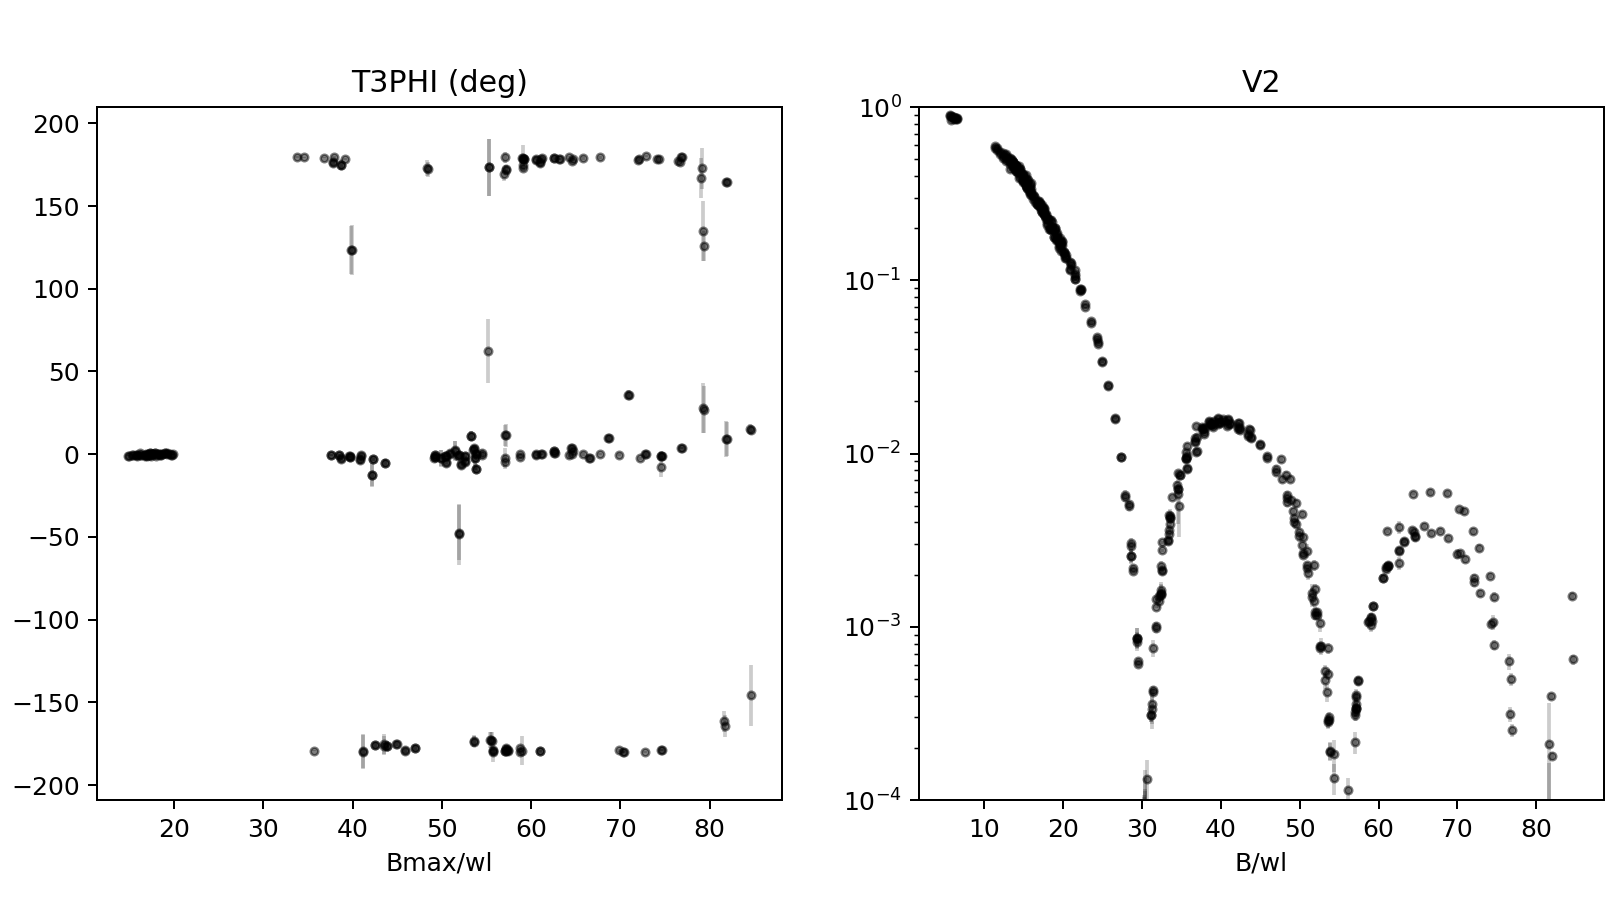

<IPython.core.display.Javascript object>


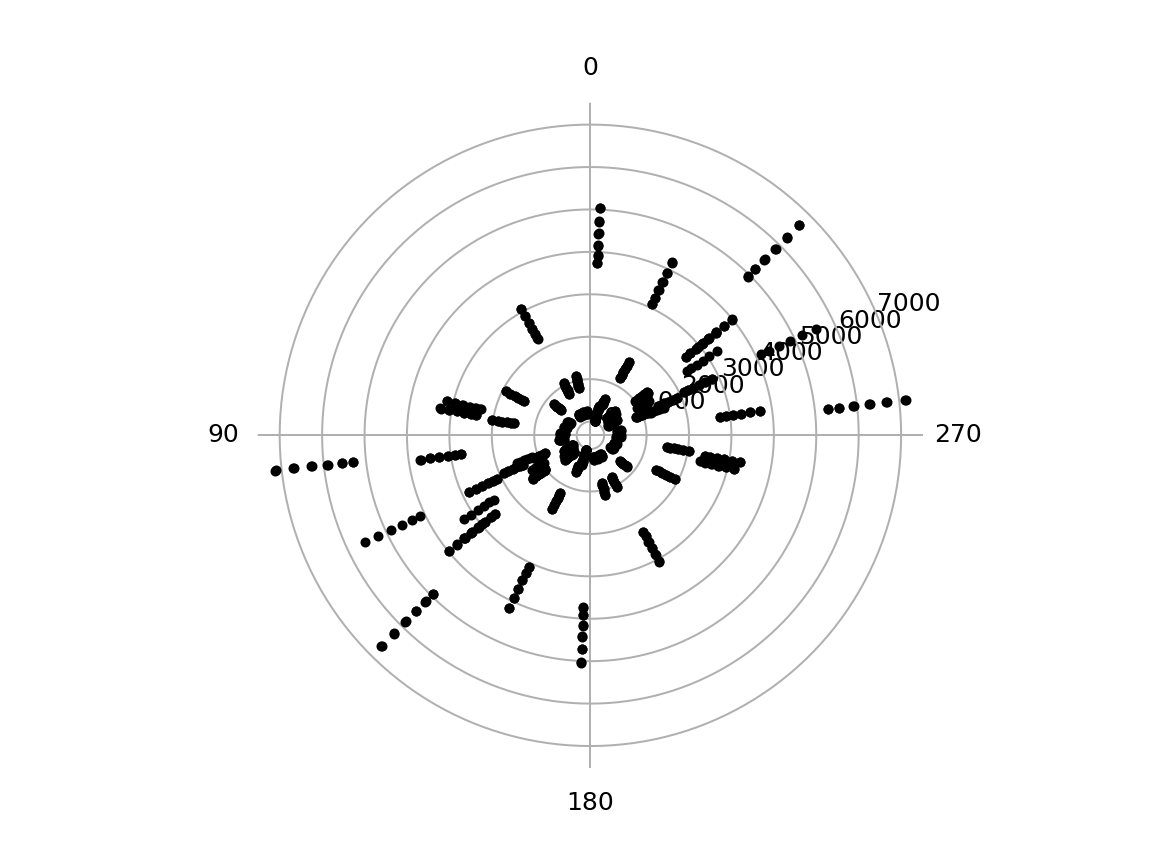

In [3]:
oimodels.showOI(data, allInOne=1, fig=1, logV=True)
oimodels.showUV(data, fig=2, polar=True)

## Fit uniform disk model
In order to fit, we need to set up:
- for each data dict `d`, we add a dict  `d['fit']`, a dictionnary itslef, containing the context of the fit:
    - `obs`: the list of observables to take into account, in `['V2', '|V|', 'T3PHI', 'DPHI', 'NFLUX']`. `T3PHI` stands for the closure phase. IN addition, there are specific observables for spectrally dospersed data: `DPHI` differential phase and `NFLUX` the flux, normalised to the continuum.
    - `min error`: a dict to set the minimum error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min error'] = {'V2':0.04}`
    - `max error`: a dict to set the maximum error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min error'] = {'V2':0.1}`
    - `wl ranges`: list of ranges ($\lambda_{min}(\mu m)$, $\lambda_{max}(\mu m)$) to restrict fit. e.g. `d['fit']['wl ranges'] = [(1.6, 1.9), (2.2, 2.3)]`. Especially useful for spectral data, to restric fit around a single line
- First guess parameters for the model. The parameters, sotred in a dictionnary, define the model. For example, a uniform disk of 8 milli-ardsecond in diameter is  `{'ud':8.0}`

The fitting function, `oimodels.fitOI` takes the data and first guess. The result is a dict containing (among other things):
- `best`: the dictionnary of best fit parameters
- `uncer`: the dictionnary of uncertainties for the best fit parameters
- `chi2`: the reduced chi2

[dpfit] 1 FITTED parameters: ['ud']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 9
[dpfit] time per function call: 11.64 (ms)
------------------------------
        CHI2= 9494.271518937468
REDUCED CHI2= 19.94594856919636
------------------------------
(uncertainty normalized to data dispersion)

{'ud': 8.3001, # +/- 0.0038
}


<IPython.core.display.Javascript object>


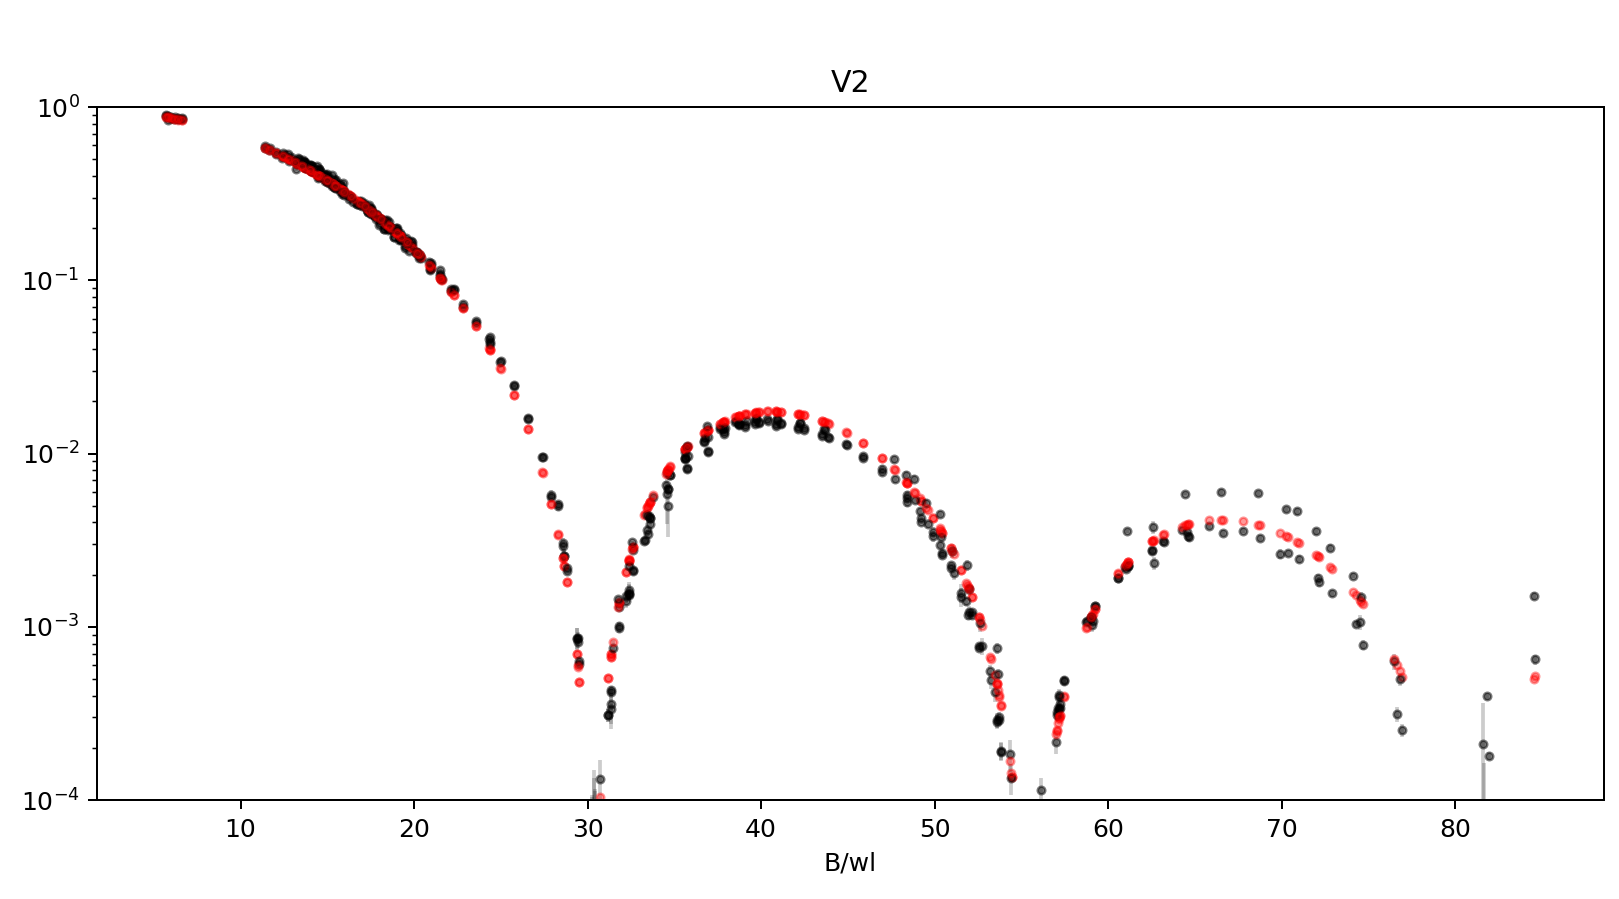

In [4]:
# -- prepare the fit, for each data file, one need to set what observable to fit
# -- can be a combination of 'V2', '|V|', 'T3PHI', 'DPHI' (differential phase) or NFLUX (normalize spectra)
for d in data:
    d['fit'] = {'obs':['V2',]}
param = {'ud':8.0, }
fitUD = oimodels.fitOI(data, param)
oimodels.showOI(data, fitUD['best'], allInOne=1, fig=3, logV=True, color='red')

## Fit a diameter with fixed Claret 4-parameters center-to-limb darkening
From Kervalla et al. A&A 597, 137 (2017), table 3:
- paper: https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract
- table 3: https://www.aanda.org/articles/aa/full_html/2017/01/aa29505-16/T3.html


[dpfit] 1 FITTED parameters: ['diam']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 13
[dpfit] time per function call: 55.4 (ms)
------------------------------
        CHI2= 5243.277602125665
REDUCED CHI2= 11.015289080095934
------------------------------
(uncertainty normalized to data dispersion)

{'diam':    8.5064, # +/- 0.0034
'profile': '1 - .7127*(1-MU**0.5) + 0.0452*(1-MU) + 0.2643*(1-MU**1.5) - 0.1311*(1-MU**2)' ,
}


<IPython.core.display.Javascript object>


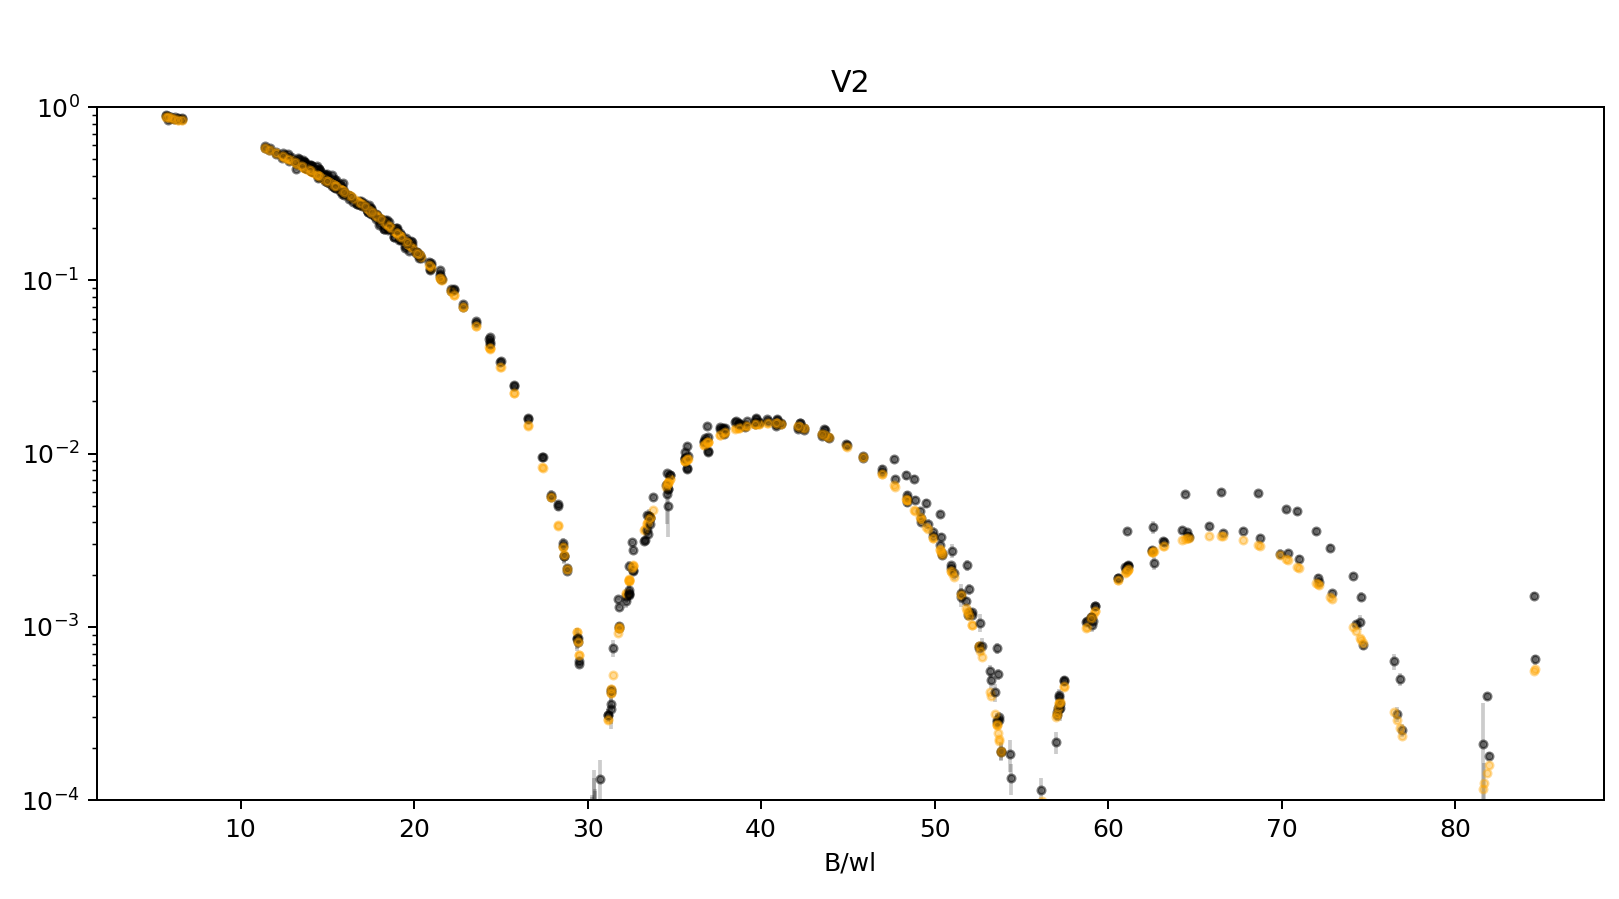

In [5]:
# -- claret 4 parameters model
for d in data:
    # -- only fit V2 and set the numbers of radial points for the computation of the intensity profile
    d['fit'] = {'obs':['V2',], 'Nr':100}
param = {'diam':8.0, 'profile':'1 - .7127*(1-MU**0.5) + 0.0452*(1-MU) + 0.2643*(1-MU**1.5) - 0.1311*(1-MU**2)'}
fitC4 = oimodels.fitOI(data, param)
oimodels.showOI(data, fitC4['best'], allInOne=1, fig=4, logV=True, color='orange')

## Fit a power law center-to-limb darkening
Both diameter and power law index are fitted. When more than one parameters are fitted, correlations between parameters will be shown, whith colors to indicate the strength of the correlation. In our example below, the correlation is very high. 

[dpfit] 2 FITTED parameters: ['diam', 'alpha']
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 25 14:17:00 2020     1 CHI2: 2.9972e+04|
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 19
[dpfit] time per function call: 54.45 (ms)
------------------------------
        CHI2= 4565.3653625811185
REDUCED CHI2= 9.611295500170776
------------------------------
(uncertainty normalized to data dispersion)

{'alpha':   0.1251, # +/- 0.0060
'diam':    8.4755, # +/- 0.0072
'profile': 'MU**alpha' ,
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
            0    1  
  0: diam ####  .91 
  1:alpha  .91 #### 


<IPython.core.display.Javascript object>


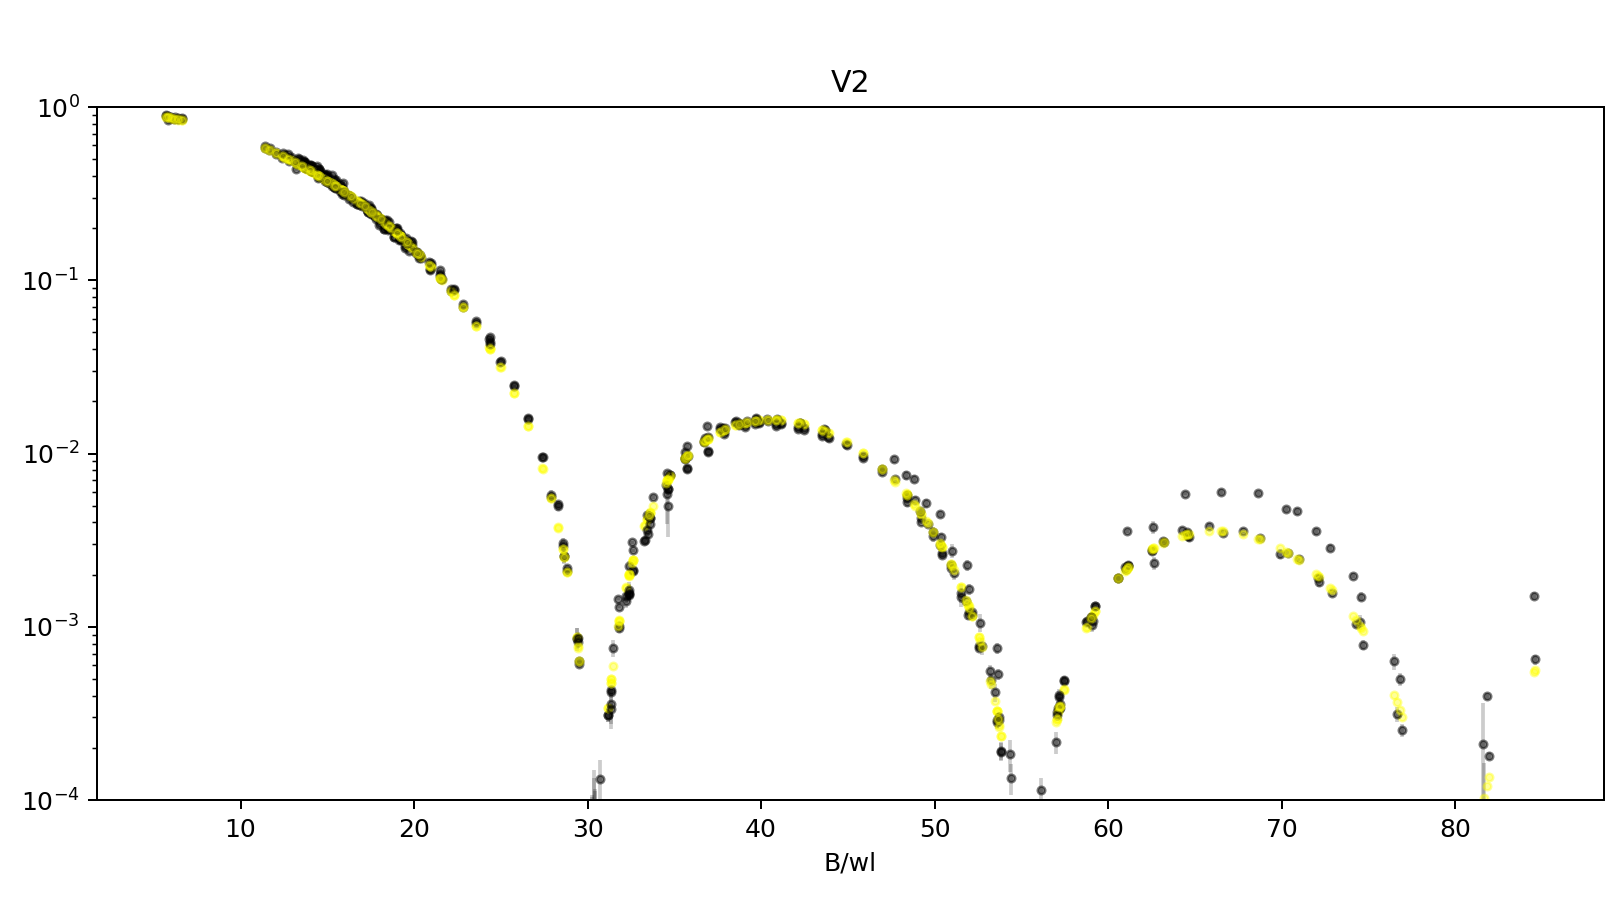

In [6]:
# -- prepare the fit, for each data file, one need to set what observable to fit
# -- can be a combination of 'V2', '|V|', 'T3PHI', 'DPHI' (differential phase) or NFLUX (normalize spectra)
for d in data:
    d['fit'] = {'obs':['V2',], 'Nr':100}
param = {'diam':8.0, 'profile':'MU**alpha', 'alpha':1.0}
fitAlpha = oimodels.fitOI(data, param)
oimodels.showOI(data, fitAlpha['best'], allInOne=1, fig=5, logV=True, color='yellow')

## Bootstrapping for better estimate of uncertainties
The reduced chi2 of fits are large. This seems to indicate that errors in data are understimated. We can bootstrap on the data and do multiple fits to estimate the scatter of estimated parameters.

Bootstrapping is achieved by drawing files randomly, with files can be drawn multiple times. One can add more randomisation, by drawing more files but removing some data inside each files. One can randomise by removing telescopes or baselines. For 4T data:
- Removing one telescope removes 3 baselines (for V2), 3 triangles (for T3PHI) and 1 flux (NFLUX). 
- Removing one baseline removes 1 baseline (for V2), 2 triangles (for T3PHI) and no flux (NFLUX). 

Note that 'oimodels.bootstrapFit' draws more files than the initial sample if telescopes or baselines are removed, to maintain the overall amount of data per drawn sample. The default randomisation is to remove one telescopes or one baseline per file drawn. Use `randomisation=None` in `oimodels.bootstrapFitOI` if you just want to draw files, without further data selection.

The bootstrap fits are filtered using a recursive sigma clipping algorithm. You can re-run the analysis (without recomputing oll the fits), by using `oimodels.analyseBootstrap` with option `sigmaClipping` (default is 4.5). When more than one parameter is explored, covariance is computed from the 2D scatter plot.

In [7]:
bootAlpha = oimodels.bootstrapFitOI(data, fitAlpha)

pooling 4 processes to run 260 fits...
one fit takes ~1.48s
it took 198.7s, 0.78s per fit on average
using 2 fits out of 260 (sigma clipping 4.50)
{'alpha'  : 0.122, # +/- 0.023
'diam'   : 8.473, # +/- 0.023
'profile': MU**alpha
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
            0    1  
  0: diam ####  .97 
  1:alpha  .97 #### 


<IPython.core.display.Javascript object>


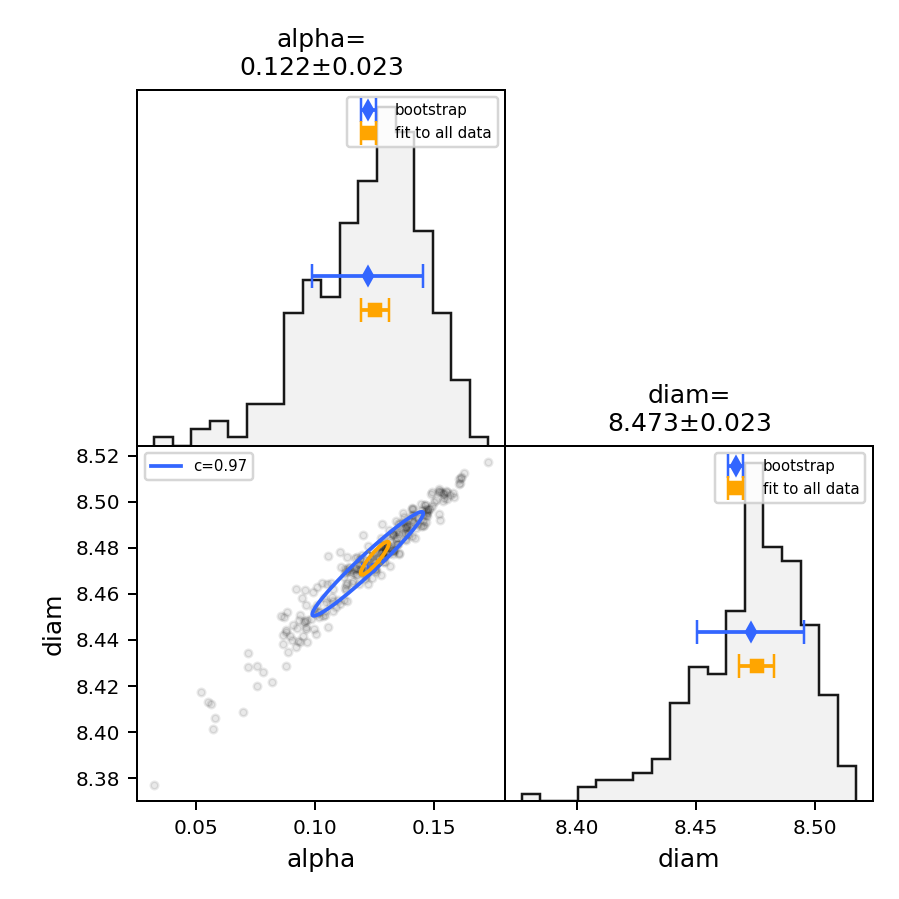

In [8]:
oimodels.showBootstrap(bootAlpha, fig=6)